In [1]:
import pickle
import numpy as np
import torch
from torch.nn import functional as F
from torch.nn.modules.container import ParameterList
from meta import Meta
import  argparse
import matplotlib.pyplot as plt
import shap

# Set parameters

In [2]:
argparser = argparse.ArgumentParser()
# argparser.add_argument('--epoch', type=int, help='epoch number', default=40000)
# argparser.add_argument('--n_way', type=int, help='n way', default=5)
# argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=32)
argparser.add_argument('--epoch', type=int, help='epoch number', default=200) #我设置的是1000
argparser.add_argument('--n_way', type=int, help='n way', default=3) #5
argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=3)
argparser.add_argument('--k_spt_test', type=int, help='k shot for support set', default=4)
argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=2) #15
argparser.add_argument('--k_qry_test', type=int, help='k shot for query set', default=10)  # 10
argparser.add_argument('--imgsz', type=int, help='imgsize', default=256)#28 64
argparser.add_argument('--imgc', type=int, help='imgchannels', default=3)
argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=4)
argparser.add_argument('--task_num_test', type=int, help='meta batch size, namely task num', default=1)
argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.1)#0.4
argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)#10
# args = argparser.parse_args()
# Filter out unrecognized arguments
args, unknown = argparser.parse_known_args()

In [ ]:
seed = 222
np.random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()
print(args)
#初始的参数
config = [
    # ****************6层卷积层参数设置256*********************
    ('conv2d', [64, 3, 3, 3, 2, 0]),  # 64种1通道3乘3卷积核 步长2 padding 0
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 3, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('flatten', []),
    # ('linear', [16, 256]),
    ('relu', [True]),
    ('linear', [args.n_way, 256])
    # ****************6层卷积层参数设置256*********************
]

Namespace(epoch=200, n_way=3, k_spt=3, k_spt_test=4, k_qry=2, k_qry_test=10, imgsz=256, imgc=3, task_num=4, task_num_test=1, meta_lr=0.001, update_lr=0.1, update_step=5, update_step_test=10)


In [4]:
# Allowlist the ParameterList class
device = torch.device('cuda')
maml = Meta(args, config).to(device)
fw = torch.load("net_vars.pth", weights_only=False, map_location=device)

In [5]:
batchsz=args.task_num
n_way=args.n_way
k_shot=args.k_spt
k_query=args.k_qry
imgsz=args.imgsz
chan=args.imgc

sample_num = 14
resize = imgsz

# Load data

In [6]:
with open('db_test_temp_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [7]:
loaded_dict

{'Incipient Fault/cable/cable2': {'MixedImg/cable20mixed_img.jpg': array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[25

In [8]:
x = []
indices = []
labels = ['Normal', 'Disturbance', 'cable2']
mapping = {'Normal': 0, 'Disturbance': 1, 'cable2': 2}
for label, imgs_dict in loaded_dict.items():
    # self.x.append(np.array(imgs))
    imgs = np.array([list(item) for item in imgs_dict.values()]) # zyg
    x.append(imgs)
    label_name = label.split('/')[-1]

    for name in imgs_dict.keys():
        indices.append(mapping[label_name])
indices = np.array(indices)
print(indices)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [9]:
x = np.array(x).astype(np.float32)
print('data shape:', x.shape)
if x.shape[0]>20:
    x_train, x_test = x[:], x[:]
else:
    x_train, x_test = x, x

data shape: (3, 14, 256, 256, 3)


In [10]:
x_test = (x_test - 2.9900356e-09) / 1.0
x_test.shape

(3, 14, 256, 256, 3)

In [11]:
x_test = np.moveaxis(x_test, -1, 2)
x_test.shape

(3, 14, 3, 256, 256)

In [12]:
x_test_reshaped = torch.tensor(x_test.reshape(-1, chan, resize, resize)).to(device)
x_test_reshaped.shape

torch.Size([42, 3, 256, 256])

In [13]:
# image = x_test_reshaped[2].cpu().numpy()
# plt.imshow(image.transpose(1, 2, 0)/255.0)
# plt.axis('off')
# plt.show()

# Test inference

In [14]:
result_pred = maml.net(x_test_reshaped, fw, bn_training=False)
# result_pred = maml.net(x_test_reshaped, fw, bn_training=True)
# print(result_pred)

## Convert logits to probabilities

In [15]:
result_prob = F.softmax(result_pred, dim=1)
result_indices = np.argmax(result_prob.cpu().detach().numpy(), axis=1)

In [16]:
result_indices

array([2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 0, 0])

In [17]:
indices == result_indices

array([ True,  True, False,  True,  True, False, False, False,  True,
       False, False, False,  True,  True,  True, False, False,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
        True,  True, False, False,  True,  True])

# Explain a single image

In [18]:
img_ID = 0
input_image = x_test_reshaped[img_ID].permute(1, 2, 0)
input_label = labels[indices[img_ID]]
input_indices = indices[img_ID]
print(f"{input_label}: {input_indices}")

cable2: 2


## Display input image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


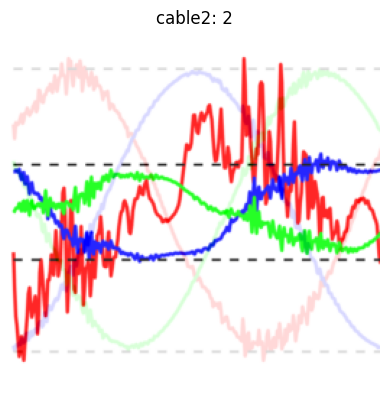

In [19]:
plt.imshow(input_image.cpu().numpy()/255.0)
plt.title(f"{input_label}: {input_indices}")
plt.axis('off')
plt.show()

In [20]:
def predict(image):
    # Convert numpy array to Tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image).float()
    
    # Ensure the image is on the correct device (e.g., GPU if available)
    image = image.to(device)
    
    return F.softmax(maml.net(image.permute(0, -1, 1, 2), fw, bn_training=True), dim=1)

In [21]:
input_image = input_image.unsqueeze(0)
predict(input_image)

tensor([[0.3574, 0.3492, 0.2934]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [22]:
input_image.shape

torch.Size([1, 256, 256, 3])

In [22]:
batch_size = 50
n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长
# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", input_image[0].shape)
# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=labels)

In [23]:
shap_values = explainer(input_image, max_evals=n_evals, batch_size=batch_size, outputs=[0,1,2])

In [24]:
input_image.shape

torch.Size([1, 256, 256, 3])

In [ ]:
shap_values.data.shape, shap_values.values.shape

(torch.Size([1, 256, 256, 3]), (1, 256, 256, 3, 3))

In [24]:
# 整理张量维度
shap_values.data = (shap_values.data).cpu().numpy()[0]/255 # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [27]:
len(shap_values.values), shap_values.values[0].shape

(3, (256, 256, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


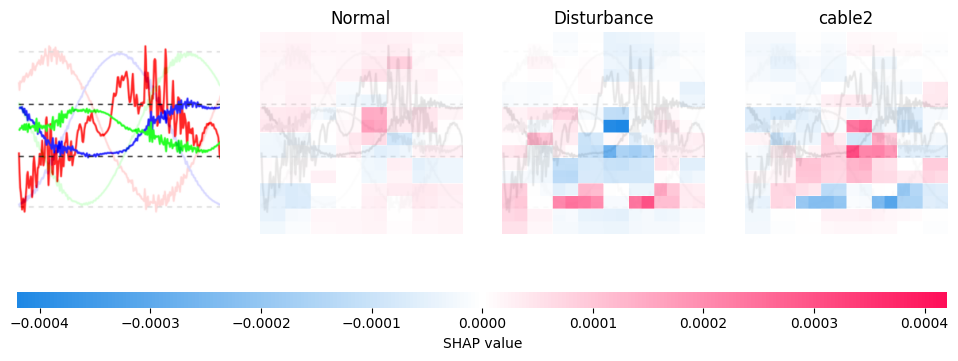

In [25]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

# Explain all images

cable2: 2
tensor([[0.7072, 0.1579, 0.1349]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


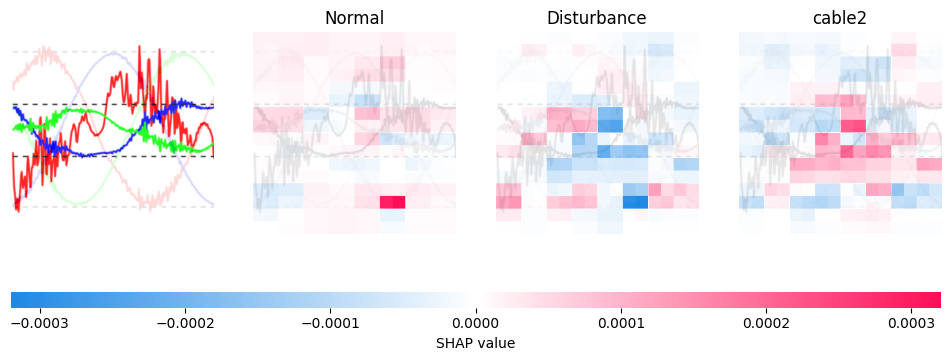

cable2: 2
tensor([[0.3443, 0.6097, 0.0460]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


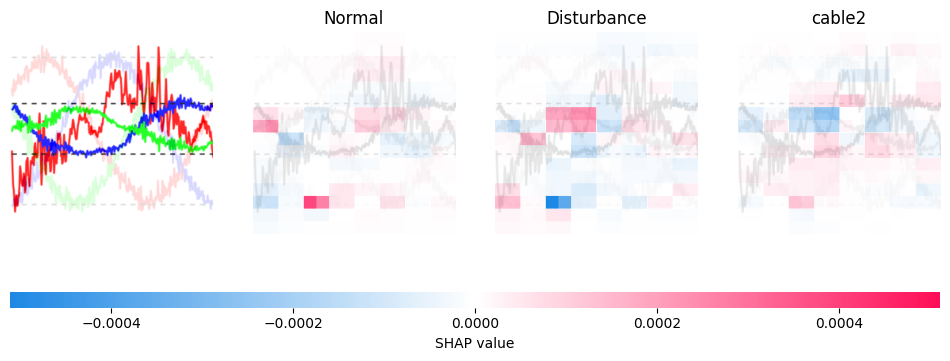

cable2: 2
tensor([[0.7556, 0.0670, 0.1774]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


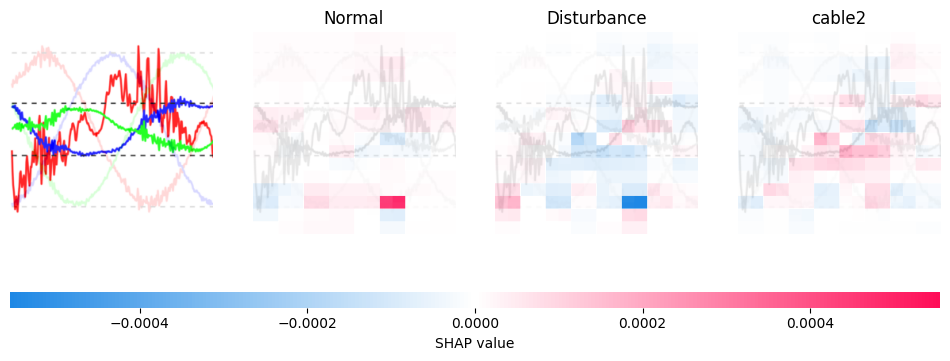

cable2: 2
tensor([[0.8067, 0.0912, 0.1021]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


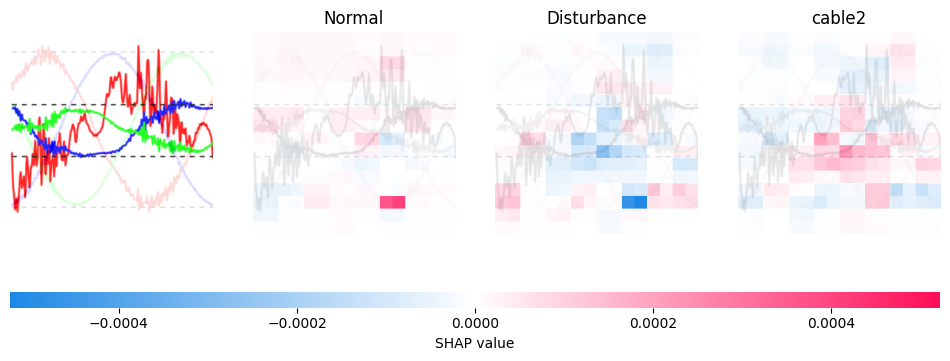

cable2: 2
tensor([[0.0520, 0.0551, 0.8929]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


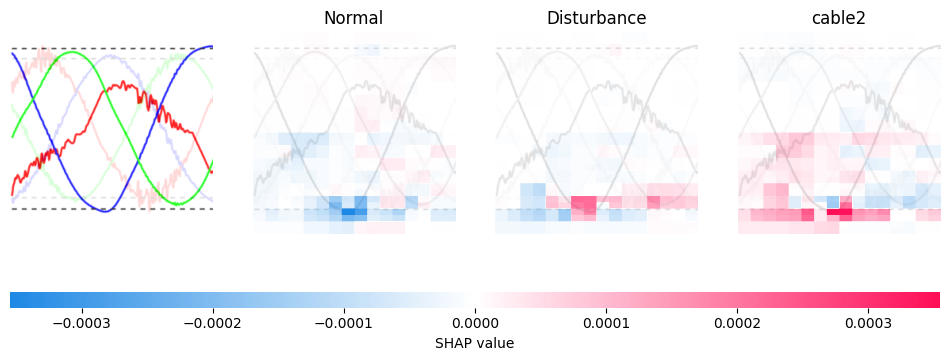

cable2: 2
tensor([[0.0138, 0.0187, 0.9675]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


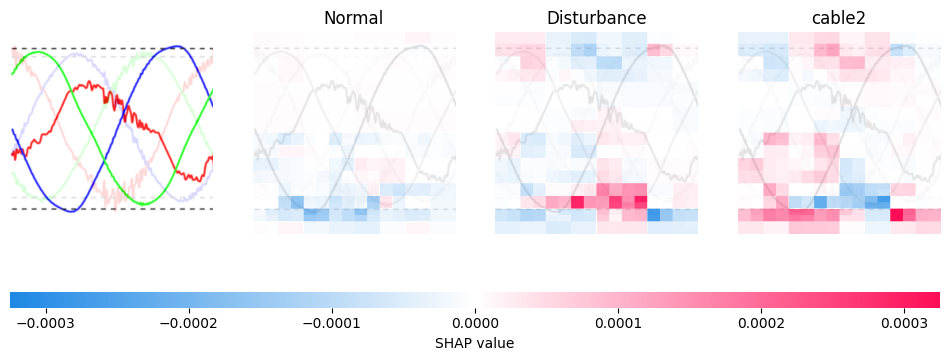

cable2: 2
tensor([[0.6533, 0.2172, 0.1295]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


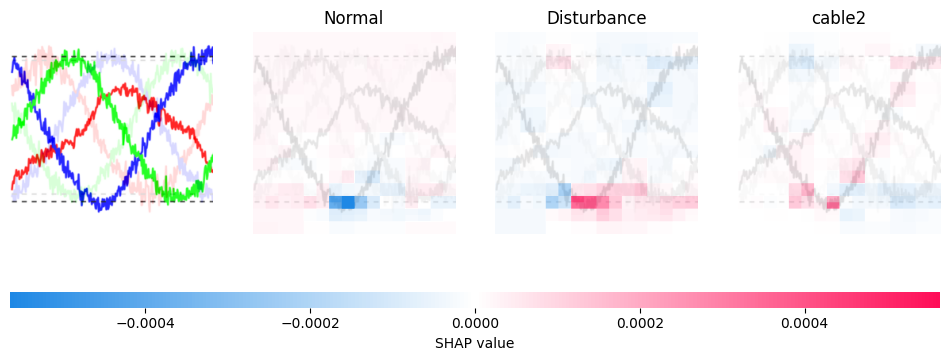

cable2: 2
tensor([[0.2268, 0.0399, 0.7333]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


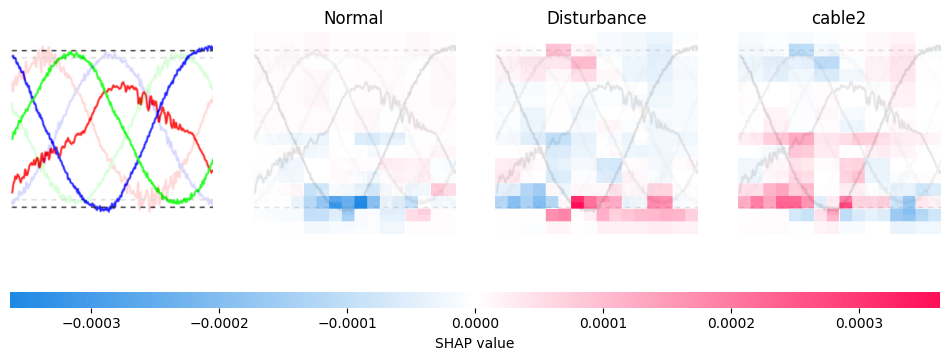

cable2: 2
tensor([[0.0220, 0.0324, 0.9456]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


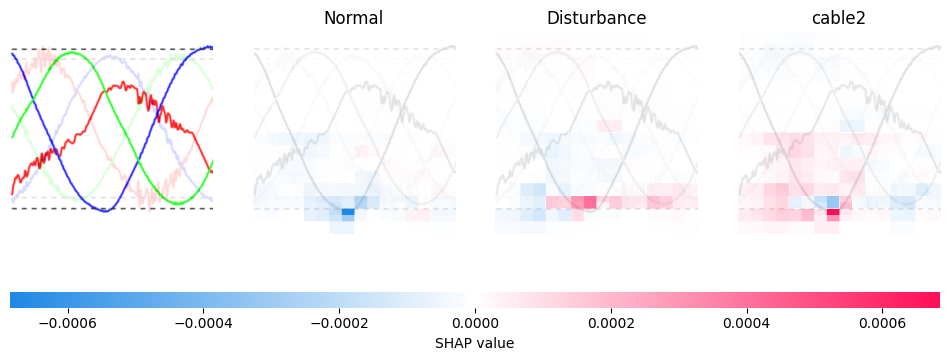

cable2: 2
tensor([[0.0994, 0.0125, 0.8881]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


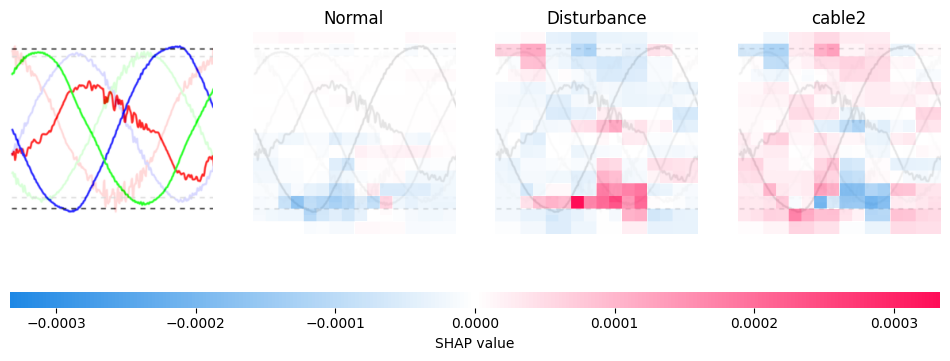

cable2: 2
tensor([[0.0160, 0.0042, 0.9798]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


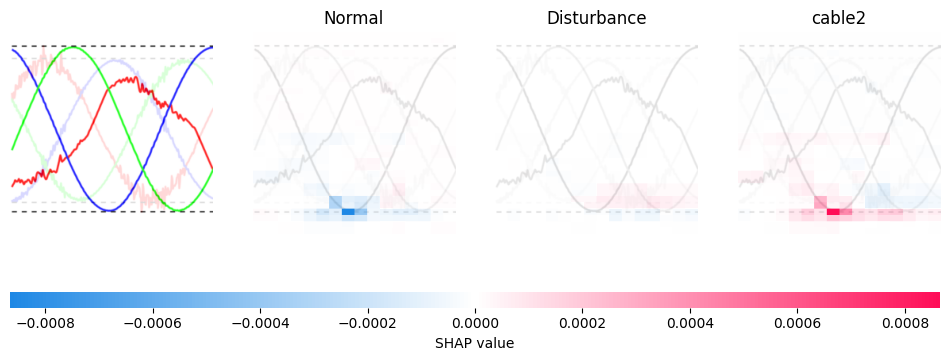

cable2: 2
tensor([[0.4017, 0.1071, 0.4912]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


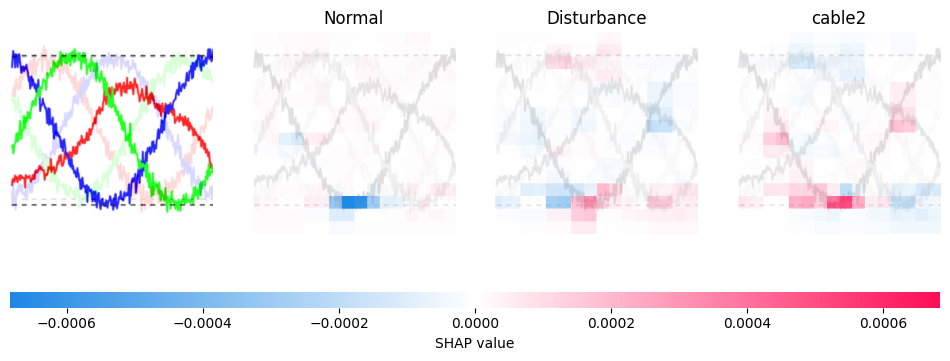

cable2: 2
tensor([[0.0267, 0.0032, 0.9701]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


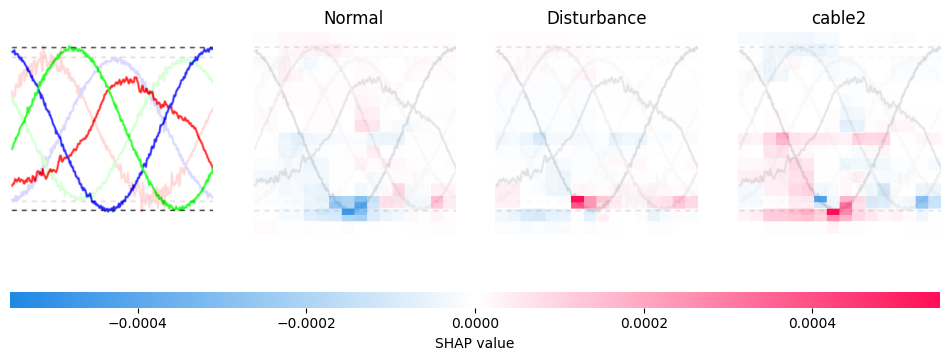

cable2: 2
tensor([[0.0179, 0.0070, 0.9751]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


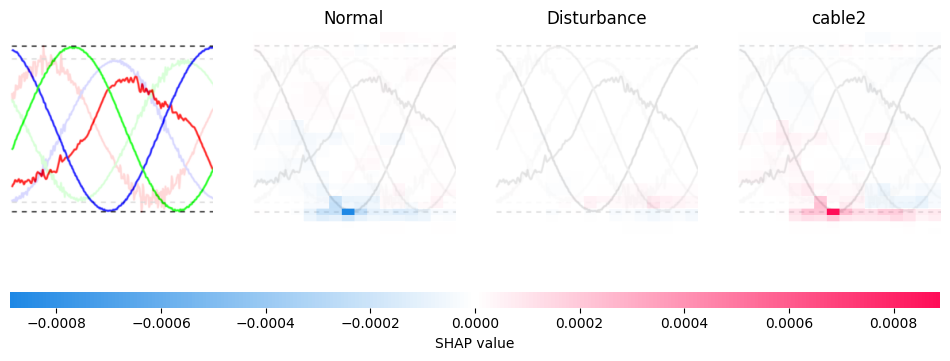

Disturbance: 1
tensor([[0.0638, 0.0733, 0.8629]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


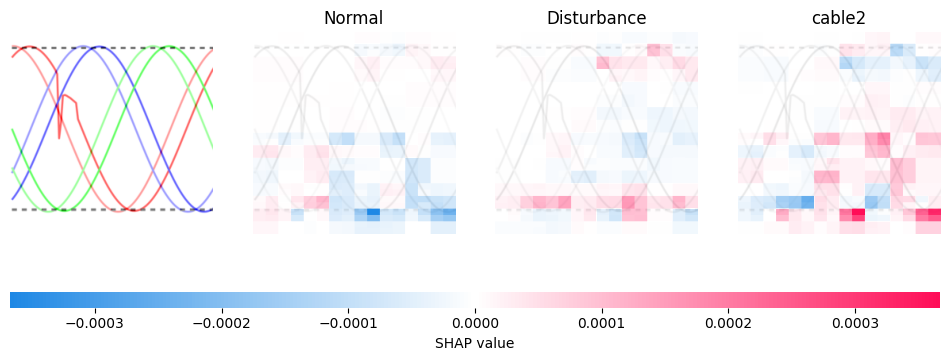

Disturbance: 1
tensor([[0.5513, 0.0092, 0.4395]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


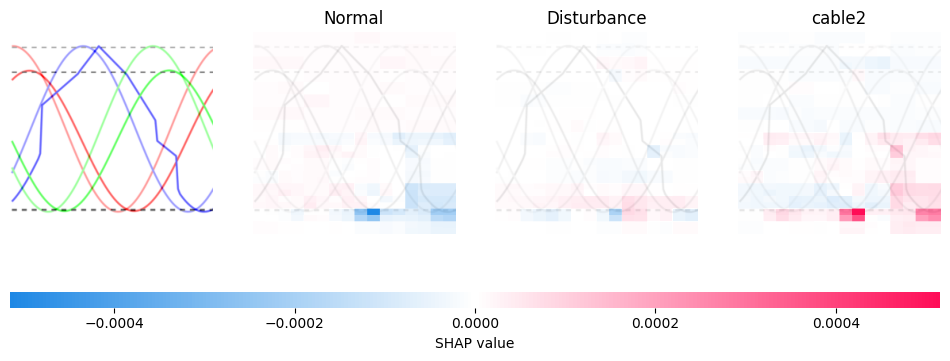

Disturbance: 1
tensor([[0.0482, 0.0482, 0.9036]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


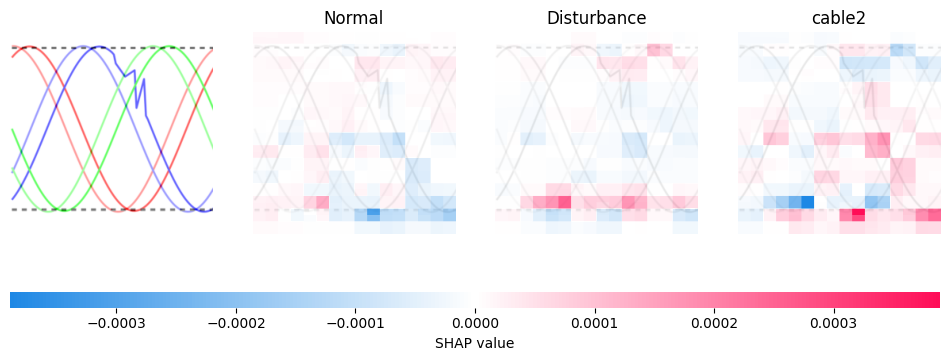

Disturbance: 1
tensor([[0.0638, 0.0733, 0.8629]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


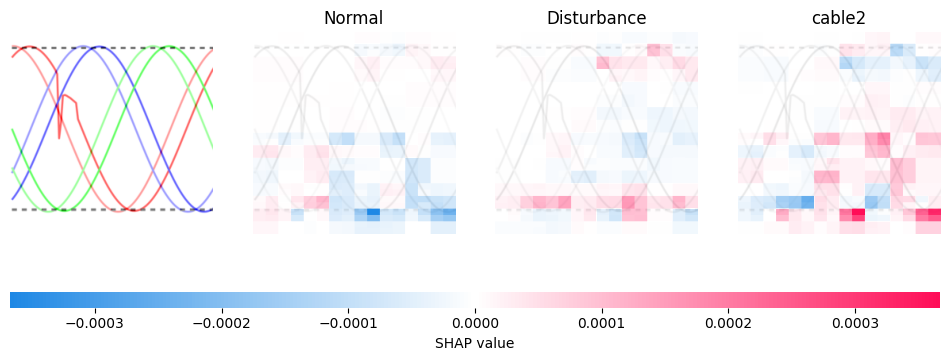

Disturbance: 1
tensor([[0.0398, 0.0162, 0.9440]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


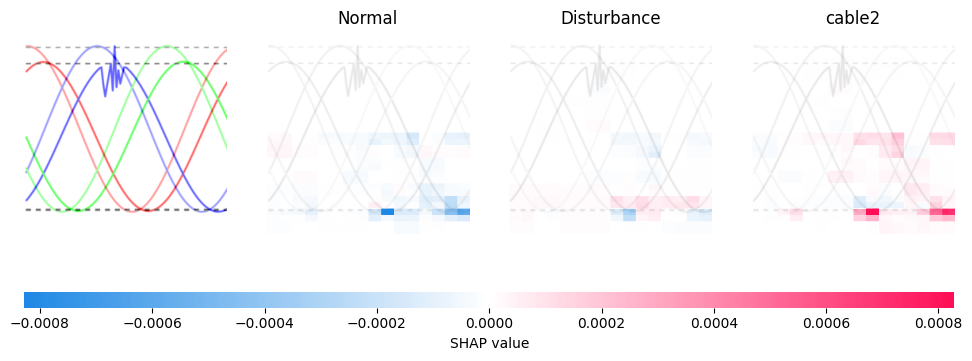

Disturbance: 1
tensor([[0.0850, 0.1167, 0.7982]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


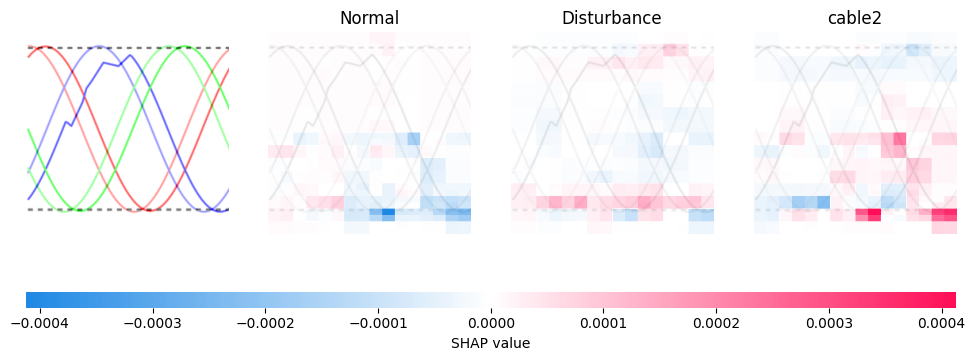

Disturbance: 1
tensor([[0.0398, 0.0162, 0.9440]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


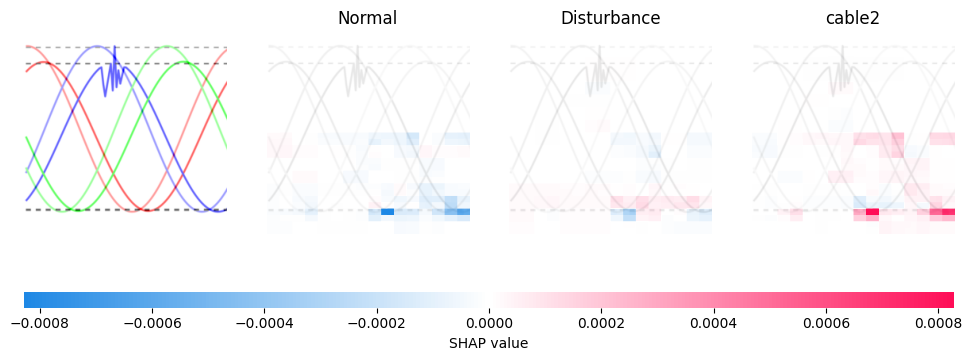

Disturbance: 1
tensor([[0.5513, 0.0092, 0.4395]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


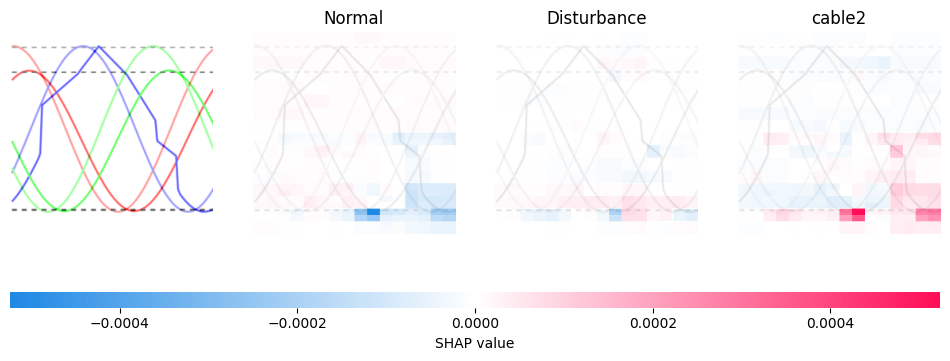

Disturbance: 1
tensor([[0.0482, 0.0482, 0.9036]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


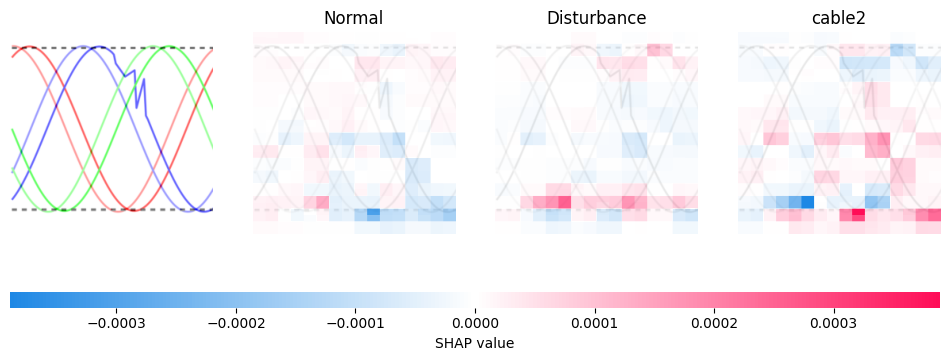

Disturbance: 1
tensor([[0.0850, 0.1167, 0.7982]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


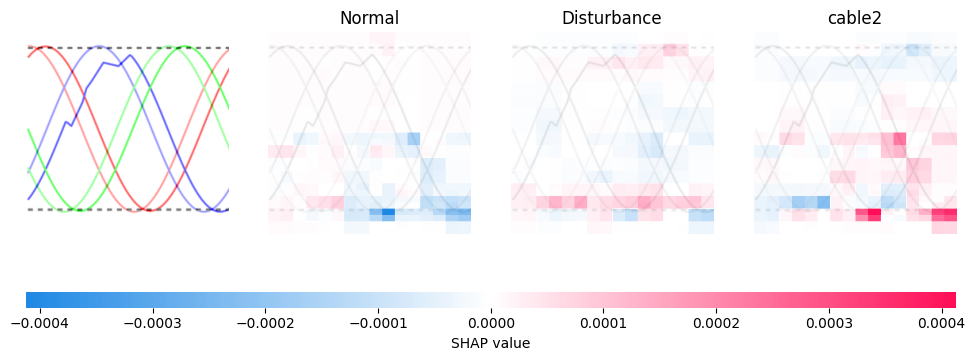

Disturbance: 1
tensor([[0.0850, 0.1167, 0.7982]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


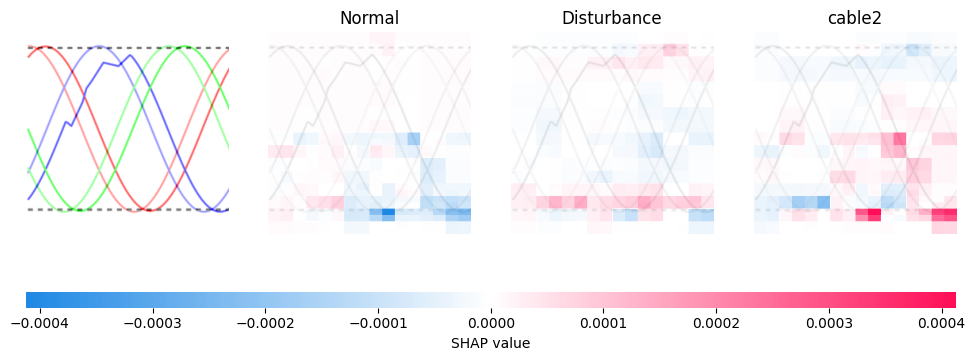

Disturbance: 1
tensor([[0.0850, 0.1167, 0.7982]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


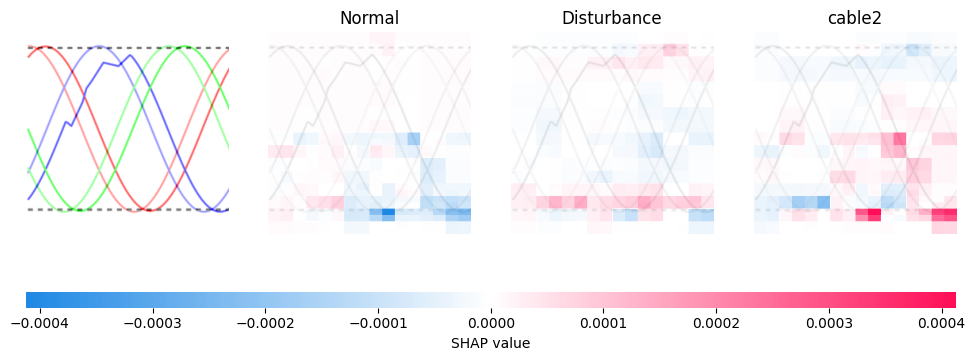

Disturbance: 1
tensor([[0.0638, 0.0733, 0.8629]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


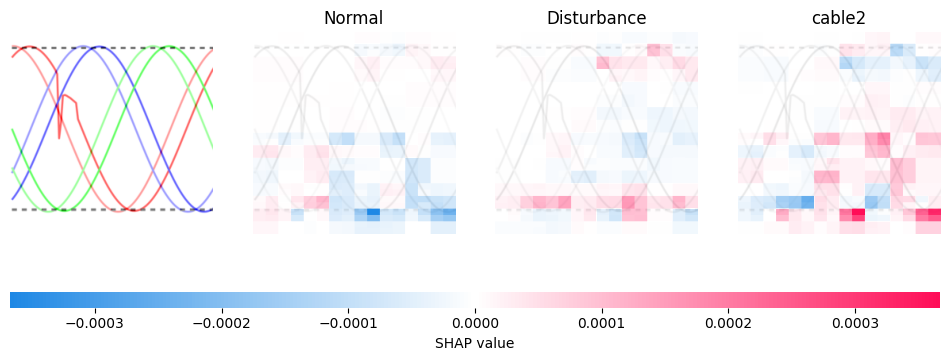

Disturbance: 1
tensor([[0.0398, 0.0162, 0.9440]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


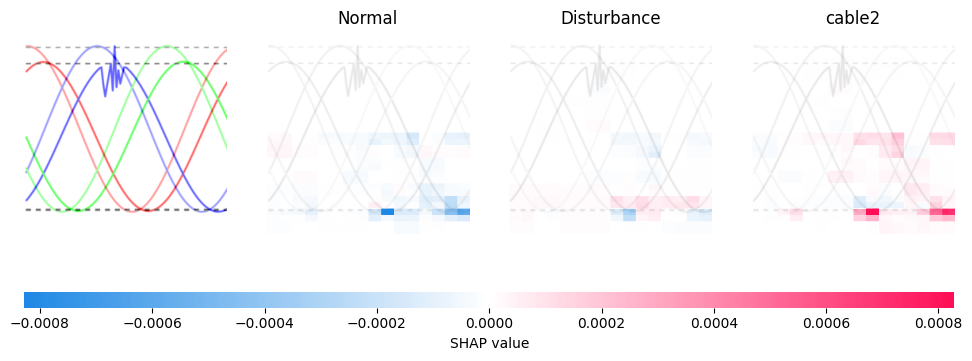

Normal: 0
tensor([[0.2487, 0.0090, 0.7423]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


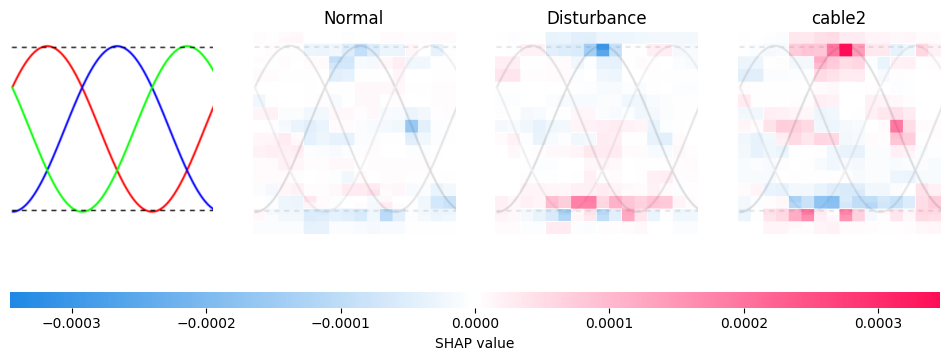

Normal: 0
tensor([[0.0298, 0.0123, 0.9579]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


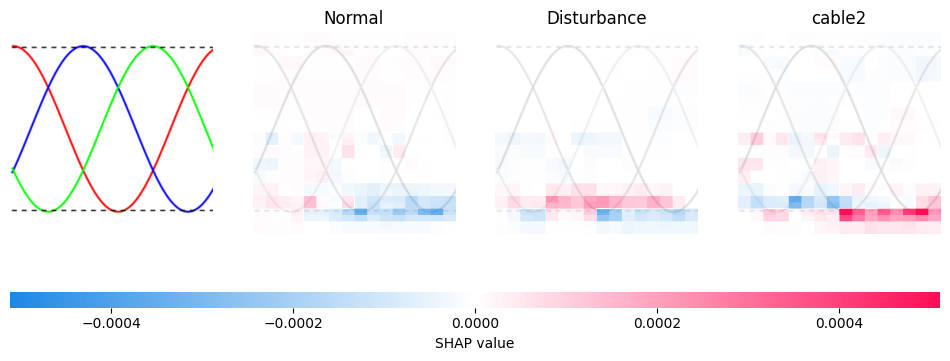

Normal: 0
tensor([[0.0298, 0.0123, 0.9579]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


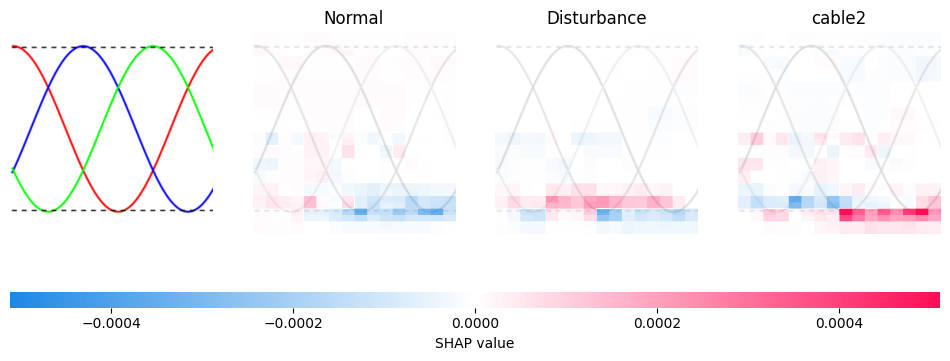

Normal: 0
tensor([[0.0298, 0.0123, 0.9579]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


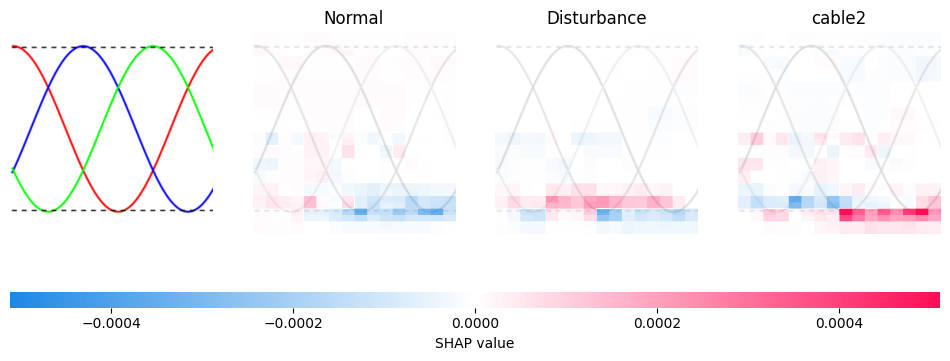

Normal: 0
tensor([[0.1017, 0.0316, 0.8667]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


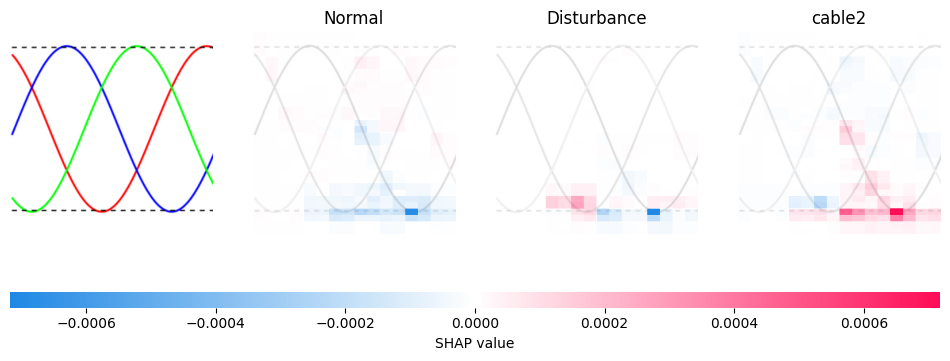

Normal: 0
tensor([[0.1017, 0.0316, 0.8667]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


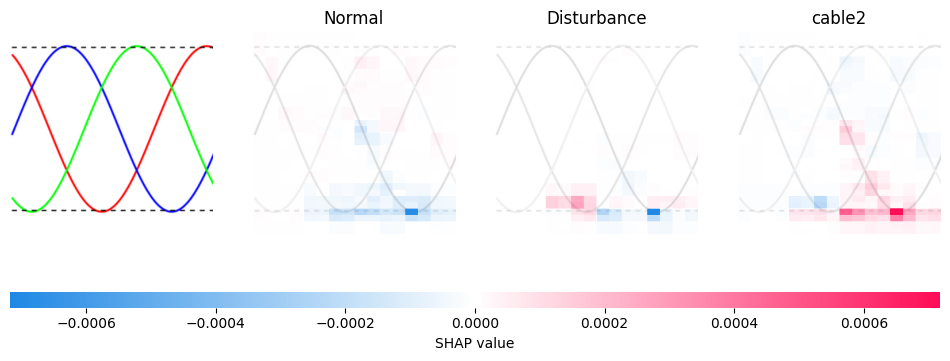

Normal: 0
tensor([[0.1017, 0.0316, 0.8667]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


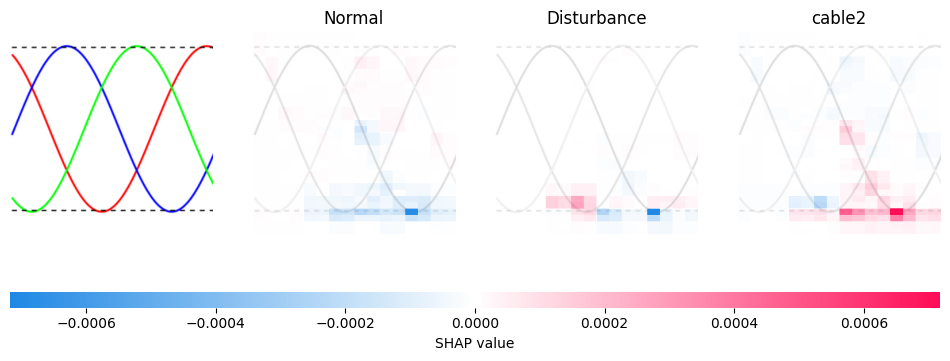

Normal: 0
tensor([[0.3402, 0.0234, 0.6364]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


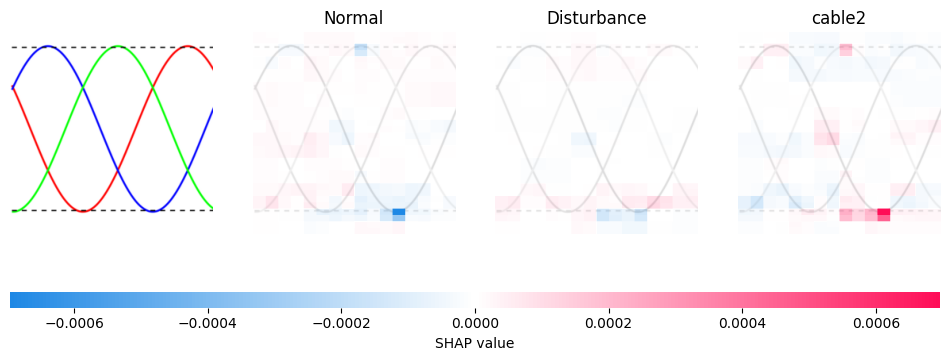

Normal: 0
tensor([[0.3402, 0.0234, 0.6364]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


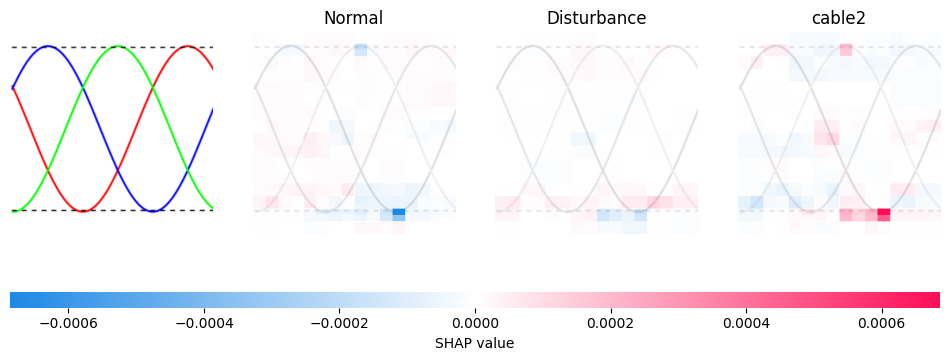

Normal: 0
tensor([[0.3402, 0.0234, 0.6364]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


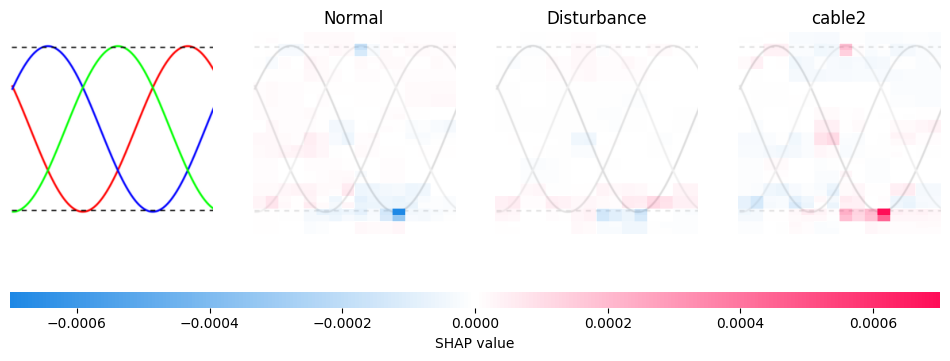

Normal: 0
tensor([[0.0635, 0.0825, 0.8540]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


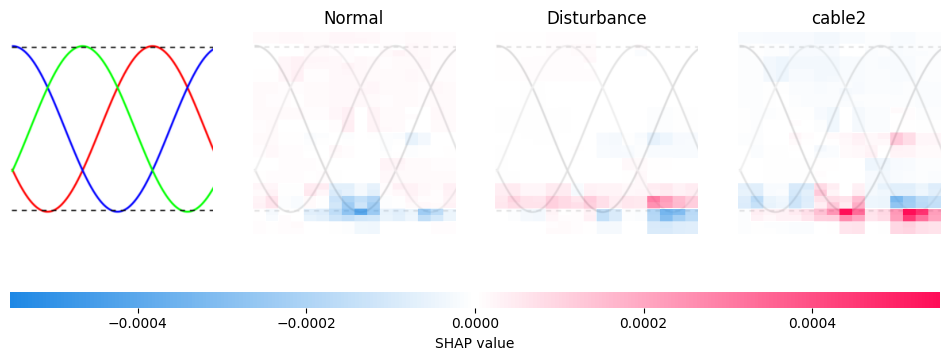

Normal: 0
tensor([[0.0635, 0.0825, 0.8540]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


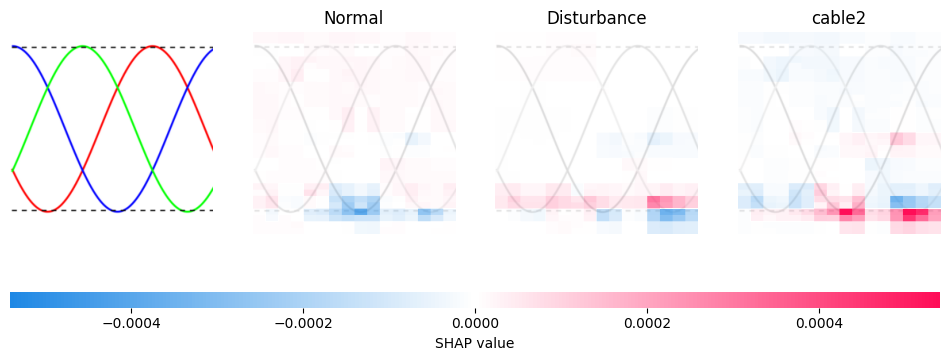

Normal: 0
tensor([[0.2487, 0.0090, 0.7423]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


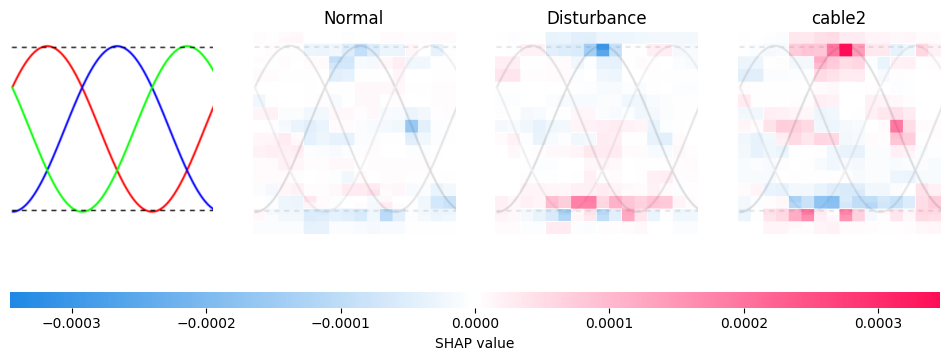

Normal: 0
tensor([[0.2487, 0.0090, 0.7423]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.172563e-11..1.0].


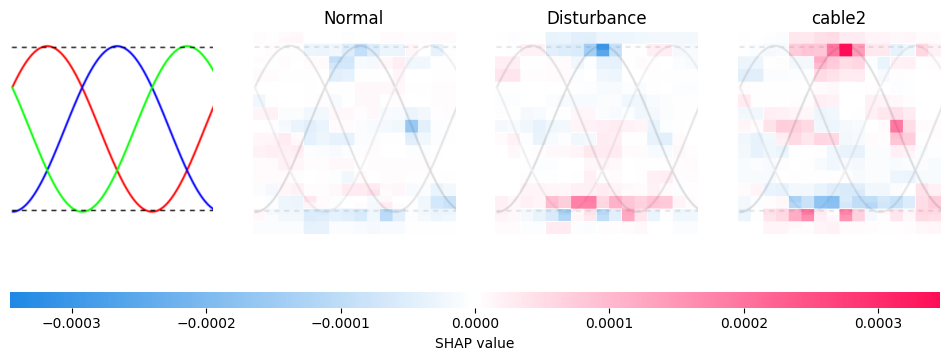

In [26]:
for img_ID in range(42):
    input_image = x_test_reshaped[img_ID].permute(1, 2, 0)
    input_label = labels[indices[img_ID]]
    input_indices = indices[img_ID]
    print(f"{input_label}: {input_indices}")

    input_image = input_image.unsqueeze(0)
    print(predict(input_image))

    batch_size = 50
    n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长
    # 定义 mask，遮盖输入图像上的局部区域
    masker_blur = shap.maskers.Image("blur(32, 32)", input_image[0].shape)
    # 创建可解释分析算法
    explainer = shap.Explainer(predict, masker_blur, output_names=labels)

    shap_values = explainer(input_image, max_evals=n_evals, batch_size=batch_size, outputs=[0,1,2])

    # 整理张量维度
    shap_values.data = (shap_values.data).cpu().numpy()[0]/255 # 原图
    shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

    # 可视化
    shap.image_plot(shap_values=shap_values.values,
                    pixel_values=shap_values.data,
                    labels=shap_values.output_names)

---

In [27]:
x_test_reshaped.shape

torch.Size([42, 3, 256, 256])

In [28]:
with torch.no_grad():
    print(maml.net(x_test_reshaped[0:10], fw, bn_training=True))

tensor([[-0.0413,  4.7249, -2.3247],
        [ 7.3200, -1.4434, -3.4971],
        [ 0.1157,  2.9858, -0.7010],
        [-0.0955,  4.7992, -2.9292],
        [-5.1828, -0.9766,  4.5414],
        [-6.4429, -3.8923,  7.8471],
        [ 4.2936, -3.9113, -2.3948],
        [ 1.4393, -5.4733,  3.7720],
        [-0.9506,  1.1589, -2.0301],
        [-1.6921, -2.0797,  1.3280]], device='cuda:0')


In [29]:
with torch.no_grad():
    print(maml.net(x_test_reshaped[0:2], fw, bn_training=True))

tensor([[-2.0768,  2.9596,  1.2033],
        [ 4.1754,  0.3935, -1.6584]], device='cuda:0')
